In [1]:
%matplotlib inline
import os
import csv
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import datasets, GeoDataFrame, read_file
import urllib.request

# import Well Location(geospatial info) csv files as Pandas dataframes

In [2]:
# Specify the columns you want to read
columns_to_read = ['WCRNUMBER', 'DECIMALLATITUDE', 'DECIMALLONGITUDE']

try:
    # Read CSV file with specified columns
    df1 = pd.read_csv("wellcompletionreports.csv", usecols=columns_to_read)
    
    # Display the first few rows to verify
    print(df1.head())
except FileNotFoundError:
    print("File not found.")
except Exception as e:
    print(f"Error: {e}")

# Function to format the decimal places safely
def format_six_decimal_places(x):
    try:
        return round(float(x), 6)
    except (ValueError, TypeError):
        return x

# Format the DECIMALLATITUDE and DECIMALLONGITUDE columns
df1['DECIMALLATITUDE'] = df1['DECIMALLATITUDE'].apply(format_six_decimal_places)
df1['DECIMALLONGITUDE'] = df1['DECIMALLONGITUDE'].apply(format_six_decimal_places)

# Display the first few rows to confirm the formatting
print(df1.head())

    WCRNUMBER  DECIMALLATITUDE  DECIMALLONGITUDE
0  WCR0234241          37.8432          -122.270
1  WCR0233981          37.4761          -121.877
2  WCR0007749          37.6585          -122.125
3  WCR0011321          37.5133          -122.015
4  WCR0004356          37.6727          -121.905
    WCRNUMBER  DECIMALLATITUDE  DECIMALLONGITUDE
0  WCR0234241          37.8432          -122.270
1  WCR0233981          37.4761          -121.877
2  WCR0007749          37.6585          -122.125
3  WCR0011321          37.5133          -122.015
4  WCR0004356          37.6727          -121.905


## Convert '/' character to decimal character
# i.e. 
# 37/41/13.06/  
# to 37+41 
# divide by /60 
# +
# 13.06 
# divide by 3600

In [3]:
def convert_latitude(lat):
    if isinstance(lat, str) and '/' in lat:
        lat_parts = lat.split('/')[:-1]  # Exclude the last element
        try:
            degrees, minutes, seconds = map(float, lat_parts)
            decimal_lat = degrees + (minutes / 60) + (seconds / 3600)
            return decimal_lat
        except ValueError:
            return None
    else:
        try:
            return float(lat)
        except (ValueError, TypeError):
            return None

def convert_longitude(lon):
    if isinstance(lon, str) and '/' in lon:
        lon_parts = lon.split('/')[:-1]  # Exclude the last element
        try:
            degrees, minutes, seconds = map(float, lon_parts)
            decimal_lon = degrees + (minutes / 60) + (seconds / 3600)
            return decimal_lon
        except ValueError:
            return None
    else:
        try:
            return float(lon)
        except (ValueError, TypeError):
            return None

In [4]:
df1['Decimal_Latitude'] = df1['DECIMALLATITUDE'].apply(convert_latitude)
df1['Decimal_Longitude'] = df1['DECIMALLONGITUDE'].apply(convert_longitude)

In [5]:
df1 = df1.dropna(subset=['DECIMALLONGITUDE','DECIMALLATITUDE'])

In [6]:
print(df1)

              WCRNUMBER  DECIMALLATITUDE  DECIMALLONGITUDE  Decimal_Latitude  \
0            WCR0234241        37.843200       -122.270000         37.843200   
1            WCR0233981        37.476100       -121.877000         37.476100   
2            WCR0007749        37.658500       -122.125000         37.658500   
3            WCR0011321        37.513300       -122.015000         37.513300   
4            WCR0004356        37.672700       -121.905000         37.672700   
...                 ...              ...               ...               ...   
1081361  WCR2015-013869        38.848056       -121.497778         38.848056   
1081362  WCR2016-017630        37.506593       -121.935042         37.506593   
1081365  WCR2014-014803        38.159722       -121.368056         38.159722   
1081366  WCR2016-008979        38.996667       -120.841944         38.996667   
1081372  WCR2015-010692        37.768014       -121.308250         37.768014   

         Decimal_Longitude  
0         

In [7]:
df1 = df1.dropna(how='all')

#only the Central Valley Stations are needed

In [8]:
aquifer_boundary = gpd.read_file('central_val_buf_5mil_wgs84.shp')

In [9]:
aquifer_boundary.plot()
aquifer_boundary.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [10]:
# WCR's locations into a geo-dataframe
WCR_CA = gpd.GeoDataFrame(
    df1, geometry=gpd.points_from_xy(df1.Decimal_Longitude, df1.Decimal_Latitude))

In [11]:
# WCR's locations ESPG
WCR_CA.crs = {'init': 'epsg:4326'}

C:\Users\betebari\AppData\Local\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [12]:
# WCR's locations 2 shapefile
WCR_CA.to_file('WCR_CA.shp', driver='ESRI Shapefile')
WCR_CA.crs

C:\Users\betebari\AppData\Local\Temp\ipykernel_27480\1802922466.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  WCR_CA.to_file('WCR_CA.shp', driver='ESRI Shapefile')


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
WCR_CA = gpd.read_file('WCR_CA.shp')

In [14]:
klip = gpd.clip(WCR_CA, aquifer_boundary)
klip.shape

(342652, 6)

In [15]:
# Reproject the GeoDataFrame to EPSG 26910
reprojected_gdf = klip.to_crs(epsg=26910)

# Add X and Y coordinates to the GeoDataFrame
reprojected_gdf['UTMX'] = reprojected_gdf.geometry.x
reprojected_gdf['UTMY'] = reprojected_gdf.geometry.y

# Check and filter out invalid coordinate values
valid_gdf = reprojected_gdf[
    reprojected_gdf['UTMX'].apply(pd.api.types.is_number) &
    reprojected_gdf['UTMY'].apply(pd.api.types.is_number) &
    reprojected_gdf['UTMX'].notna() &
    reprojected_gdf['UTMY'].notna()
]

# Ensure the GeoDataFrame is not empty
if valid_gdf.empty:
    raise ValueError("All records have invalid coordinate values.")

# Assign the valid GeoDataFrame to df1
df1 = valid_gdf

# Print the GeoDataFrame to verify
print(df1.head())

# Save the valid GeoDataFrame to a new shapefile
valid_gdf.to_file("Reprojected_Valid.shp")

         WCRNUMBER  DECIMALLAT  DECIMALLON  Decimal_La  Decimal_Lo  \
209910  WCR0124101     34.8399    -118.916     34.8399    -118.916   
200754  WCR0050844     34.8399    -118.916     34.8399    -118.916   
213276  WCR0021028     34.8399    -118.916     34.8399    -118.916   
213865  WCR0289261     34.8399    -118.916     34.8399    -118.916   
202105  WCR0151370     34.8399    -118.916     34.8399    -118.916   

                              geometry           UTMX          UTMY  
209910  POINT (873506.922 3862901.262)  873506.921762  3.862901e+06  
200754  POINT (873506.922 3862901.262)  873506.921762  3.862901e+06  
213276  POINT (873506.922 3862901.262)  873506.921762  3.862901e+06  
213865  POINT (873506.922 3862901.262)  873506.921762  3.862901e+06  
202105  POINT (873506.922 3862901.262)  873506.921762  3.862901e+06  


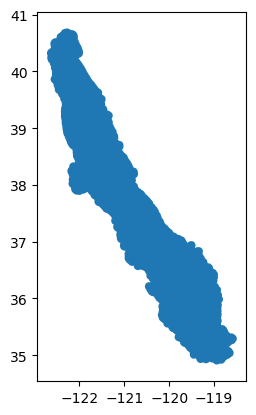

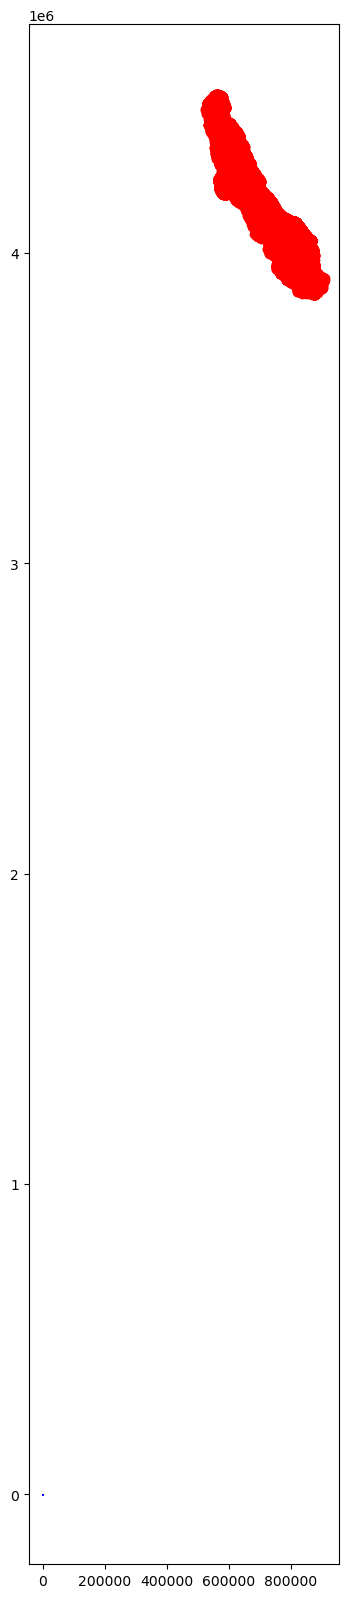

In [16]:
ax = aquifer_boundary.plot(figsize=(20, 20),color='white', edgecolor='blue')
# We can now plot our ``GeoDataFrame``.
df1.plot(figsize=(20, 20),ax=ax, color='red')
plt.show()

In [17]:
df2 = pd.DataFrame(df1, copy=True)

#join two table of water levels and stations

In [18]:
df2.to_csv('OSWCRgeospatial_central_valley.csv')

# export Clip's attribute tabe to csv file

In [19]:
# Vlookup lat-longs from original dataframe, since lattude and longitudes were rounded to the nearest
# 3 or 4 decimal places

In [20]:
# List of columns to drop
columns_to_drop = ['DECIMALLAT', 'DECIMALLON', 'Decimal_La', 'Decimal_Lo', 'geometry']

# Drop the columns from df2
df2 = df2.drop(columns=columns_to_drop)

# Display the modified dataframe
print(df2)

             WCRNUMBER           UTMX          UTMY
209910      WCR0124101  873506.921762  3.862901e+06
200754      WCR0050844  873506.921762  3.862901e+06
213276      WCR0021028  873506.921762  3.862901e+06
213865      WCR0289261  873506.921762  3.862901e+06
202105      WCR0151370  873506.921762  3.862901e+06
...                ...            ...           ...
813510  WCR1999-009058  556817.687483  4.510712e+06
826682  WCR2006-007563  564837.996223  4.510789e+06
825319  WCR2007-008885  564837.996223  4.510789e+06
825035  WCR2007-008884  564837.996223  4.510789e+06
813991  WCR2007-008886  564837.996223  4.510789e+06

[342652 rows x 3 columns]


In [21]:
print("DataFrame 1:\n", df1)
print("\nDataFrame 2:\n", df2)

DataFrame 1:
              WCRNUMBER  DECIMALLAT  DECIMALLON  Decimal_La  Decimal_Lo  \
209910      WCR0124101     34.8399    -118.916     34.8399    -118.916   
200754      WCR0050844     34.8399    -118.916     34.8399    -118.916   
213276      WCR0021028     34.8399    -118.916     34.8399    -118.916   
213865      WCR0289261     34.8399    -118.916     34.8399    -118.916   
202105      WCR0151370     34.8399    -118.916     34.8399    -118.916   
...                ...         ...         ...         ...         ...   
813510  WCR1999-009058     40.7454    -122.327     40.7454    -122.327   
826682  WCR2006-007563     40.7455    -122.232     40.7455    -122.232   
825319  WCR2007-008885     40.7455    -122.232     40.7455    -122.232   
825035  WCR2007-008884     40.7455    -122.232     40.7455    -122.232   
813991  WCR2007-008886     40.7455    -122.232     40.7455    -122.232   

                              geometry           UTMX          UTMY  
209910  POINT (873506.922 3

In [22]:
# Merge df1 and df2 on 'WCRNUMBER'
merged_df = pd.merge(df1, df2, on='WCRNUMBER', how='inner')

# Display the column names to verify the merge
print("Columns in merged_df:", merged_df.columns)

# Drop columns that are no longer needed (adjust column names as needed)
merged_df.drop(columns=['Decimal_La', 'Decimal_Lo','geometry'], inplace=True, errors='ignore')

# Drop rows with any NaN values
merged_df.dropna(inplace=True)

# Optionally, set display precision for floating point numbers (for visualization only)
pd.set_option('display.float_format', '{:.6f}'.format)

# Drop the intermediate column
merged_df = merged_df.drop(['UTMX_x','UTMY_x'], axis=1)

merged_df.head()

Columns in merged_df: Index(['WCRNUMBER', 'DECIMALLAT', 'DECIMALLON', 'Decimal_La', 'Decimal_Lo',
       'geometry', 'UTMX_x', 'UTMY_x', 'UTMX_y', 'UTMY_y'],
      dtype='object')


,WCRNUMBER,DECIMALLAT,DECIMALLON,UTMX_y,UTMY_y
0,WCR0124101,34.839900,-118.916000,873506.921762,3862901.261997
1,WCR0050844,34.839900,-118.916000,873506.921762,3862901.261997
2,WCR0021028,34.839900,-118.916000,873506.921762,3862901.261997
3,WCR0289261,34.839900,-118.916000,873506.921762,3862901.261997
4,WCR0151370,34.839900,-118.916000,873506.921762,3862901.261997


In [23]:
merged_df.to_csv('UPDATED_wellcompletionreports.csv')